# Основные этапы работы:
1. Загрузка и подготовка данных

2. Минимальная предобработка текста

3.  Выбор и обучения модели

4.  Оценка качетсва модели

Для построения модели классификации тональности текстов на русском языке использовалась модель на базе трансформеров RuBERT, поскольку. Одними из главных преимуществ данной модели является то, что:
- она обучена на русском (а значит, распознает морфологию, склонения, падежи);
- поддерживает регистр;
- достигает высоких значений macro-F1;
- устойчиво к шумным данных, что является одним из ключевых критериев выбора

Для нас в первую очередь было важно качетсво нашей модели (метрика), а не скорость, хотя, безусловно, это также важно. Дополнительно также рассматривались такие модели, как rubert-tiny2 (легкая, быстрая, менее устойчива к шуму, не было претрейна на соцтекстах) и RuRoberta-base от Сбера (большой размер модели, возможность переобучения, медленная скорость)

# 1. Загрузка и подготовка данных
- загрузка датасетов
- разделение train  на обучающую и валидационную выборки
- преобразование в Dataset-формат библиотеки huggingFace

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset
from sklearn.metrics import f1_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
import torch

2025-11-30 00:08:25.044945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764461305.219125      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764461305.269434      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train = pd.read_csv('/kaggle/input/hackaton/train.csv')
test = pd.read_csv('/kaggle/input/hackaton/test.csv')
sample = pd.read_csv('/kaggle/input/hackaton/sample_submission.csv')

In [3]:
train.head(10)

,ID,text,src,label
0,26739,smaller than in description.,rureviews,0
1,198426,Слева от меня Алексей Ильмухин. Путешественник...,rusentiment,1
2,172615,"Ребёнок в садик отходил год, из них пол года п...",geo,2
3,246532,Замерзла на -15,perekrestok,2
4,209852,"Как всегда, название не соответствует истинном...",kinopoisk,0
5,27996,"Очень долго,ну прям очень, две недели только о...",rureviews,0
6,39836,Очень понравились штинишки))) качество супер! ...,rureviews,1
7,48753,"Футболка классная,качество отличное",rureviews,1
8,273666,"Достоинства:\nПриятный для кожи,приятно пахнуш...",perekrestok,1
9,46430,"Покупкой довольна! На рост 175см, ОГ 105см сел...",rureviews,1


In [4]:
test.head(10)

,ID,text,src
0,174475,Наблюдал веселую картину: сотрудник сто чуть н...,geo
1,86578,"После просмотра данного анимэ, странное чувств...",anime
2,231392,платье велико !\n\n\n\n\n\nВиталий.\n\ne-mail:...,ru-reviews-classification
3,7802,"качество отвратительное, колючая. нет ни перед...",rureviews
4,278930,Достоинства: Густая и очень вкусная Моя любима...,perekrestok
5,175969,"Сегодня звонила узнать про вишню декоративную,...",geo
6,122536,Лично моя оценка это 5. Потому что вся история...,anime
7,209162,"Богиня... как я полюбила.\n\nВключив это кино,...",kinopoisk
8,244087,Не пользовались,perekrestok
9,125520,"Гостиница ну ровно на 3 звезды, точно как в на...",geo


In [5]:
sample.head(10)

,ID,label
0,174475,0.0
1,86578,0.0
2,231392,0.0
3,7802,0.0
4,278930,0.0
5,175969,0.0
6,122536,0.0
7,209162,0.0
8,244087,0.0
9,125520,0.0


In [6]:
print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (232366, 4)
Размер тестовой выборки: (58092, 3)


In [7]:
if 'src' in train.columns:
    train = train.drop(columns=['src'])
if 'ID' in train.columns:
    train = train.drop(columns=['ID'])
test_ids = test['ID'].values if 'ID' in test.columns else None
if 'src' in test.columns:
    test_texts = test.drop(columns=['src'])
else:
    test_texts = test.copy()
test_texts = test_texts.drop(columns=['ID'], errors='ignore')

print("Пропущенные значения в train:", train.isnull().sum().to_dict())
print("Пропущенные значения в test(тексты):", test_texts.isnull().sum().to_dict())
train['label'] = train['label'].astype(int)
train.dtypes


Пропущенные значения в train: {'text': 0, 'label': 0}
Пропущенные значения в test(тексты): {'text': 0}


text     object
label     int64
dtype: object

Количество примеров по классам:
Класс 0: 77243
Класс 1: 77494
Класс 2: 77629


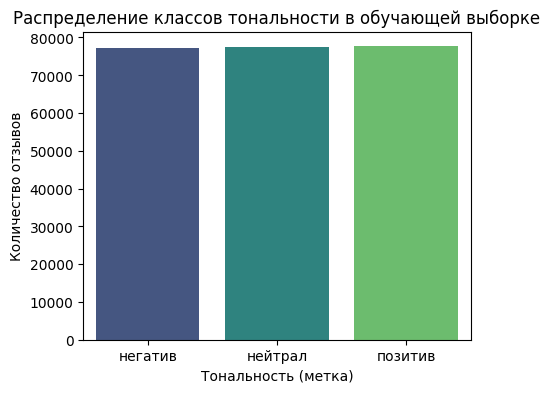

In [8]:
label_counts = train['label'].value_counts().sort_index()
print("Количество примеров по классам:")
for label, count in label_counts.items():
    print(f"Класс {label}: {count}")

# График распределения классов
plt.figure(figsize=(5,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Распределение классов тональности в обучающей выборке")
plt.xlabel("Тональность (метка)")
plt.ylabel("Количество отзывов")
plt.xticks([0,1,2], ["негатив", "нейтрал", "позитив"])
plt.show()


In [9]:
examples_per_class = 1
for lbl in [0, 1, 2]:
    subset = train[train['label'] == lbl]
    print(f"\nПример {examples_per_class} из класса {lbl} ({'негатив' if lbl==0 else 'нейтрал' if lbl==1 else 'позитив'}):")
    print(subset['text'].iloc[0][:200], "...")



Пример 1 из класса 0 (негатив):
smaller than in description. ...

Пример 1 из класса 1 (нейтрал):
Слева от меня Алексей Ильмухин. Путешественник и интересный человек. В числе его личных побед - путешествие на велосипеде от Челябинска до Байкала... Приехал к нам помочь в организации семинара Мухтар ...

Пример 1 из класса 2 (позитив):
Ребёнок в садик отходил год, из них пол года просто на больничном. На вопрос почему детей не осматривает утром медсестра, ответ дали простой -она ж не врач!!! Зачем тогда она нужна в садике? Только пр ...


In [10]:
train, val = train_test_split(train, test_size=0.1, stratify=train['label'], random_state=42)
print("Обучающая выборка:", train.shape)
print("Валидационная выборка:", val.shape)
print("Распределение классов в валидации:", val['label'].value_counts(normalize=True).round(2).to_dict())


Обучающая выборка: (209129, 2)
Валидационная выборка: (23237, 2)
Распределение классов в валидации: {2: 0.33, 1: 0.33, 0: 0.33}


# 2. Предобработка текста
- предобработка данных была ограничена встроенной токенизацией WordPiece от RuBERT
- лемматизация и стемминг не применялись, поскольку могут ухудшить качество модели из-за потери контекста
- удаление стоп-слов и знаков препинания не проводилось по той же причине (тоже потеря контекста
- использовалась модель 'cased', поэтому регистр слов сохранялся


# 3. Выбор и обучение модели
- была выбрана предобученная модель 'DeepPavlov/rubert-base-cased',поскольку она специально адаптирована для русского языка;
- модель дообучалась в течение 3 эпох с использованием Trainer из HuggingFace;
- для метрики качества использовалась метрика macro-F1;
- лучшая модель сохранялась автоматически при обучении

## 1 модель - RuBert

In [11]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
# создаем Dataset-объекты из DataFrame (сброс индексов для корректности)
train_dataset = Dataset.from_pandas(train.reset_index(drop=True))
val_dataset   = Dataset.from_pandas(val.reset_index(drop=True))
test_dataset  = Dataset.from_pandas(test_texts.reset_index(drop=True))

# функция токенизации для батча текстов
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

# применяем токенизацию batched
train_dataset = train_dataset.map(tokenize_batch, batched=True, batch_size=1000)
val_dataset   = val_dataset.map(tokenize_batch, batched=True, batch_size=1000)
test_dataset  = test_dataset.map(tokenize_batch, batched=True, batch_size=1000)

# Удаляем оригинальный текст из датасетов, чтобы остались только токенизированные данные (и метки для train/val)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset   = val_dataset.remove_columns(["text"])
test_dataset  = test_dataset.remove_columns(["text"])
# Проверим формат полученных данных
print(train_dataset)
print(train_dataset[0])


Map:   0%|          | 0/209129 [00:00<?, ? examples/s]

Map:   0%|          | 0/23237 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 209129
})
{'label': 0, 'input_ids': [101, 38616, 12552, 2739, 2067, 16039, 132, 100288, 67581, 53136, 10340, 128, 625, 9650, 6345, 4139, 61534, 132, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [16]:
model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3)

# Определяем функцию для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {"macro_f1": macro_f1}

training_args = TrainingArguments(
    output_dir="rubert-sentiment-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    fp16=True,
    seed=42,
    report_to="none"
)

# объект для динамического паддинга
data_collator = DataCollatorWithPadding(tokenizer)

# инициализируем тренер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3302320599.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(model.device)

cuda:0


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1
1,0.600100,0.582384,0.742152
2,0.519500,0.567727,0.747650
3,0.456600,0.583754,0.752473


TrainOutput(global_step=4902, training_loss=0.5394957910893353, metrics={'train_runtime': 6821.3425, 'train_samples_per_second': 91.974, 'train_steps_per_second': 0.719, 'total_flos': 4.126848445202918e+16, 'train_loss': 0.5394957910893353, 'epoch': 3.0})

# 4. Оценка качества
- оценка производилась на валидационной выборке по метрике macro-F1;
- после завершения обучения были получены предсказания на тестовом наборе и сформирован submission.csv;


In [20]:
eval_metrics = trainer.evaluate(eval_dataset=val_dataset)
print(f"Macro-F1 на валидации: {eval_metrics['eval_macro_f1']:.4f}")

Macro-F1 на валидации: 0.7525


In [18]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")
print("Модель и токенизатор сохранены")

Модель и токенизатор сохранены


In [ ]:
!zip -r sentiment_model.zip sentiment_model

In [19]:
test_pred_logits = trainer.predict(test_dataset).predictions
test_preds = np.argmax(test_pred_logits, axis=1)

submission = sample.copy()
submission['label'] = test_preds
submission['label'] = submission['label'].astype(int)  # убедимся, что метки целочисленные
submission.to_csv('submission.csv', index=False)
submission.head(10)


,ID,label
0,174475,0
1,86578,0
2,231392,0
3,7802,0
4,278930,0
5,175969,0
6,122536,0
7,209162,0
8,244087,0
9,125520,0


# Возможные улучшения

**ПРИМЕЧАНИЕ**: каждое из данных улучшений было реализовано на практике, но в разных версиях notebook. Поэтому в объединенном файле ячеки кода в блоке "Возможные улучшения" не запущены

## 1) Ансамблирование моделей
У нас было несколько путей реализации нескольких улучшений. Первая из них: ансамблирование из 3 моделей:
- RuBERT-base-cased (transformer)
- RuBERT-tiny2 (быстрый, компактный transformer)
- TF-IDF + логистическая регрессия (простая линейная модель).
- Ансамблирование в нашем случае повысит устоциваость и качество, а дальше происходит усреднение вероятностей (soft voting)

In [ ]:
# модель1: RuBERT-base-cased
model1 = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3)
trainer1 = Trainer(model=model1, tokenizer=tokenizer)
probs1 = softmax(trainer1.predict(test_dataset).predictions, axis=1)

# модель2: RuBERT-tiny2
model2 = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=3)
trainer2 = Trainer(model=model2, tokenizer=tokenizer)
probs2 = softmax(trainer2.predict(test_dataset).predictions, axis=1)

In [ ]:
# ввод: test_texts (pd.Series/list с чистым текстом)
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(train["text"])
X_test_tfidf = vectorizer.transform(test_texts)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, train["label"])

probs3 = logreg.predict_proba(X_test_tfidf)

In [ ]:
# усредняем вероятности (можно использовать разные веса)
ensemble_probs = (probs1 + probs2 + probs3) / 3
final_preds = np.argmax(ensemble_probs, axis=1)

# готовим submission
submission = sample.copy()
submission['label'] = final_preds
submission.to_csv("ensemble_submission.csv", index=False)

## 2) Стратифицированная кросс-валидация
Позволяет обучить модель на разных подвыборках, сохраняя пропорции классов. Помогает сделать модель более устойчивой к случайным выбросам.
В конце предсказания усредняются

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import f1_score
import torch

# Фиксируем seed
def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Кол-во фолдов
N_SPLITS = 3
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Заготовка для предсказаний
all_logits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['label'])):
    print(f"\nFold {fold+1}/{N_SPLITS}")
    
    # Разделение на train/val
    df_train = train.iloc[train_idx].reset_index(drop=True)
    df_val   = train.iloc[val_idx].reset_index(drop=True)

    # Dataset + токенизация
    train_dataset = Dataset.from_pandas(df_train)
    val_dataset   = Dataset.from_pandas(df_val)

    def tokenize_batch(batch):
        return tokenizer(batch['text'], truncation=True, max_length=128)

    train_dataset = train_dataset.map(tokenize_batch, batched=True).remove_columns(["text"])
    val_dataset = val_dataset.map(tokenize_batch, batched=True).remove_columns(["text"])

    # Модель
    model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3)

    # Метрики
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        macro_f1 = f1_score(labels, preds, average='macro')
        return {"macro_f1": macro_f1}

    # Аргументы обучения
    training_args = TrainingArguments(
        output_dir=f"rubert-fold{fold+1}",
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=3,
        per_device_train_batch_size=128,
        per_device_eval_batch_size=64,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=500,
        fp16=True,
        report_to="none",
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Предсказания на тесте
    test_logits = trainer.predict(test_dataset).predictions
    all_logits.append(test_logits)

# Усредняем логиты
avg_logits = np.mean(all_logits, axis=0)
preds = np.argmax(avg_logits, axis=1)

# Submission
submission = sample.copy()
submission['label'] = preds
submission.to_csv("submission_kfold_ensemble.csv", index=False)
print(submission.head())

## 3) Scheduler и Gradient Clipping
Scheduler помогает плавно изменять learning rate. Gradient clipping — предотвращает взрыв градиентов при обучении.
